In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pingouin as pg
import scipy
import scipy.cluster.hierarchy as sch

sns.set()
sns.set_style("white")

In [2]:
df = pd.read_csv('allTogether.csv')

# remove ids and numbers
df = df.drop(['_id','question.number','user._id'], axis=1)
# groupNames, majLabel and colors are synonyms
df = df.drop(['question.groupNames','question.colors'], axis=1)

# encode categorial data
label_encoder = LabelEncoder()
df['question.majLabel'] = label_encoder.fit_transform(df['question.majLabel']).astype('float64')
df['user.language'] = label_encoder.fit_transform(df['user.language']).astype('float64')
df['user.age'] = label_encoder.fit_transform(df['user.age']).astype('float64')
df['user.edu'] = label_encoder.fit_transform(df['user.edu'].astype('str')).astype('float64')
df['user.gender'] = label_encoder.fit_transform(df['user.gender'].astype('str')).astype('float64')

# rND is labeled in reverse
df['question.new_rND'] = 2 - df['question.new_rND']

# add absolute version of the rND score (demographic parity)
df['question.abs_rND'] = df['question.new_rND']
df.loc[df['question.new_rND']>1, 'question.abs_rND'] = 2-df['question.new_rND']

# add absolute version of the cv score (demographic parity)
df['question.abs_cv'] = df['question.cv']
df.loc[df['question.cv']>1, 'question.abs_cv'] = 2-df['question.cv']
# add absolute versions of comparative accuracy scores
df['question.abs_s_tnr'] = df['question.s_tnr']
df.loc[df['question.s_tnr']>1, 'question.abs_s_tnr'] = 2-df['question.s_tnr']
df['question.abs_s_tpr'] = df['question.s_tpr']
df.loc[df['question.s_tpr']>1, 'question.abs_s_tpr'] = 2-df['question.s_tpr']
df['question.abs_s_bcr'] = df['question.s_bcr']
df.loc[df['question.s_bcr']>1, 'question.abs_s_bcr'] = 2-df['question.s_bcr']
# add absolute versions of comparative adjusted accuracy scores
df['question.abs_s_adj_tnr'] = df['question.s_adj_tnr']
df.loc[df['question.s_adj_tnr']>1, 'question.abs_s_adj_tnr'] = 2-df['question.s_adj_tnr']
df['question.abs_s_adj_tpr'] = df['question.s_adj_tpr']
df.loc[df['question.s_adj_tpr']>1, 'question.abs_s_adj_tpr'] = 2-df['question.s_adj_tpr']
df['question.abs_s_adj_bcr'] = df['question.s_adj_bcr']
df.loc[df['question.s_adj_bcr']>1, 'question.abs_s_adj_bcr'] = 2-df['question.s_adj_bcr']
pd.set_option('display.max_columns', None)
df.head()

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.abs_rND,question.abs_cv,question.abs_s_tnr,question.abs_s_tpr,question.abs_s_bcr,question.abs_s_adj_tnr,question.abs_s_adj_tpr,question.abs_s_adj_bcr
0,0.89,0.84,36.534,selection,3,7,0.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.00,1.000000,NaN,NaN,1.000000,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,NaN,NaN,NaN,NaN,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.5,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.285714,NaN,1.000000,NaN,NaN,1.000000,NaN
1,0.58,NaN,16.849,selection,5,5,0.0,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.80,0.854167,1.000000,0.927083,0.898551,1.0,0.5,0.75,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,NaN,NaN,NaN,NaN,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.5,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.600000,0.500000,0.666667,0.916667,0.666667,0.854167,0.906250
2,0.39,0.06,12.849,selection,4,6,1.0,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.75,1.000000,0.791045,0.895522,0.827160,0.5,1.0,0.75,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,NaN,NaN,NaN,NaN,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.5,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.666667,0.666667,0.500000,0.916667,0.791045,0.730769,0.969862
3,0.25,NaN,10.424,selection,4,6,0.0,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.50,0.395349,1.000000,0.697674,0.500000,1.0,0.6,0.80,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,NaN,NaN,NaN,NaN,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.5,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.750000,0.600000,0.333333,0.866667,0.747967,0.395349,0.823691
4,0.05,0.13,8.199,selection,1,9,0.0,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.00,NaN,0.000000,NaN,0.000000,0.0,1.0,0.50,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,NaN,NaN,NaN,NaN,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.5,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN


In [3]:
ran_scores = [
    'question.ordering_utility',
    'question.sum_of_diff',
    'question.new_rND',
    'question.abs_rND',
    'question.rND'
]
df_sel = df.query("`question.questionType` == 'selection'").drop(ran_scores, axis=1)
df_sel

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.abs_cv,question.abs_s_tnr,question.abs_s_tpr,question.abs_s_bcr,question.abs_s_adj_tnr,question.abs_s_adj_tpr,question.abs_s_adj_bcr
0,0.89,0.84,36.534,selection,3,7,0.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.285714,NaN,1.000000,NaN,NaN,1.000000,NaN
1,0.58,NaN,16.849,selection,5,5,0.0,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.800000,0.854167,1.000000,0.927083,0.898551,1.0,0.500000,0.750000,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.600000,0.500000,0.666667,0.916667,0.666667,0.854167,0.906250
2,0.39,0.06,12.849,selection,4,6,1.0,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.750000,1.000000,0.791045,0.895522,0.827160,0.5,1.000000,0.750000,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.666667,0.666667,0.500000,0.916667,0.791045,0.730769,0.969862
3,0.25,NaN,10.424,selection,4,6,0.0,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.500000,0.395349,1.000000,0.697674,0.500000,1.0,0.600000,0.800000,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.750000,0.600000,0.333333,0.866667,0.747967,0.395349,0.823691
4,0.05,0.13,8.199,selection,1,9,0.0,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.0,1.000000,0.500000,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.70,0.82,35.312,selection,4,6,1.0,0.875000,0.500000,0.687500,0.8,0.965753,0.583333,0.774543,0.936709,1.000000,0.000000,0.500000,0.750000,1.000000,0.000000,0.500000,0.863636,0.8,1.000000,0.900000,0.833333,0.929293,1.000000,0.964646,0.933962,1.200000,0.000000,0.600000,0.916667,1.070707,0.000000,0.535354

In [4]:
sel_scores = [
    'question.tpr',
    'question.tnr',
    'question.bcr',
    'question.accuracy',
    'question.adj_tpr',
    'question.adj_tnr',
    'question.adj_bcr',
    'question.adj_accuracy',
    'question.tpr0',
    'question.tnr0',
    'question.bcr0',
    'question.accuracy0',
    'question.adj_tpr0',
    'question.adj_tnr0',
    'question.adj_bcr0',
    'question.adj_accuracy0',
    'question.tpr1',
    'question.tnr1',
    'question.bcr1',
    'question.accuracy1',
    'question.adj_tpr1',
    'question.adj_tnr1',
    'question.adj_bcr1',
    'question.adj_accuracy1',
    'question.s_tpr',
    'question.s_tnr',
    'question.s_bcr',
    'question.s_accuracy',
    'question.s_adj_tpr',
    'question.s_adj_tnr',
    'question.s_adj_bcr',
    'question.s_adj_accuracy',
    'question.abs_s_tpr',
    'question.abs_s_tnr',
    'question.abs_s_bcr',
    'question.abs_s_adj_tpr',
    'question.abs_s_adj_tnr',
    'question.abs_s_adj_bcr',
    'question.cv',
    'question.abs_cv'
]
df_ran = df.query("`question.questionType` == 'ranking'").drop(sel_scores, axis=1)
df_ran

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.abs_rND
10,0.36,NaN,30.358,ranking,4,6,1.0,14,0.555556,0.622642,0.524177,0.523612,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.523612
11,0.59,NaN,12.189,ranking,4,6,1.0,16,0.594595,0.790000,0.444673,0.650439,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.650439
12,0.45,0.01,8.107,ranking,2,8,1.0,17,0.255814,0.494949,0.171153,0.997906,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.997906
13,0.61,0.06,11.920,ranking,5,5,0.0,12,0.717391,0.840336,0.272121,0.546572,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.546572
14,0.49,NaN,9.950,ranking,5,5,1.0,18,0.617647,0.718750,0.374144,0.996520,0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.996520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,0.14,NaN,6.142,ranking,4,6,1.0,17,0.297297,0.560000,0.250514,0.355276,0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,0.355276
2706,0.26,NaN,11.163,ranking,5,5,0.0,12,0.657895,0.825688,0.237616,1.521316,0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,0.478684
2707,0.21,NaN,13.815,ranking,5,5,0.0,13,0.318182,0.462264,0.249202,1.504024,0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,0.495976
2708,0.81,0.10,9.210,ranking,4,6,1.0,14,0.948718,0.980392,0.547559,1.813790,0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,0.186210


In [5]:
# signifiant correlations for selection questions
corr_sel = pg.pairwise_corr(df_sel, columns=['rating'], method='spearman') # use spearman because of distribution of ratings
corr_sel[corr_sel['p-unc']<0.05].sort_values(by=['adj_r2'], ascending=False).drop(['tail','n','CI95%','r2','r','power'], axis=1)

,X,Y,method,adj_r2,z,p-unc
9,rating,question.adj_tpr,spearman,0.491219,0.870075,5.335345e-199
12,rating,question.adj_accuracy,spearman,0.475947,0.848814,1.200577e-192
11,rating,question.adj_bcr,spearman,0.470550,0.841390,7.226596e-187
8,rating,question.accuracy,spearman,0.442351,0.803004,2.315534e-174
7,rating,question.bcr,spearman,0.430845,0.787565,2.370119e-168
27,rating,question.adj_bcr1,spearman,0.419883,0.773069,3.577026e-148
23,rating,question.bcr1,spearman,0.416887,0.769090,8.558267e-147
5,rating,question.tpr,spearman,0.415911,0.767683,9.941638e-161
28,rating,question.adj_accuracy1,spearman,0.408033,0.757257,8.727808e-157
64,rating,question.abs_s_adj_tpr,spearman,0.398176,0.744541,1.975431e-123


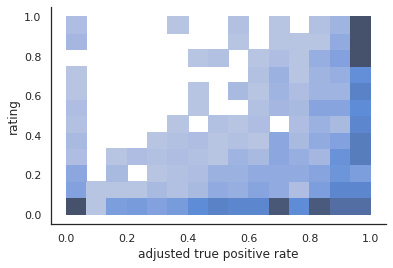

In [6]:
ax = sns.histplot(df_sel, x='question.adj_tpr', y='rating', pmax=0.7)
ax.set(xlabel='adjusted true positive rate')
sns.despine()

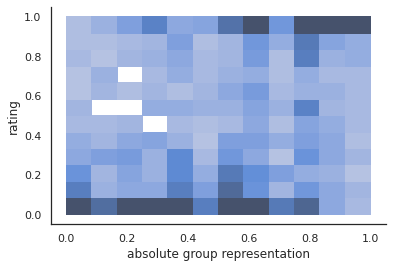

In [7]:
ax = sns.histplot(df_sel, x='question.abs_cv', y='rating', pmax=0.7)
ax.set(xlabel='absolute group representation')
sns.despine()

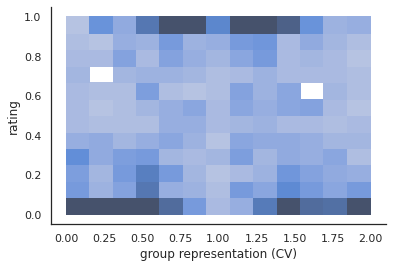

In [8]:
ax = sns.histplot(df_sel, x='question.cv', y='rating', pmax=0.7)
ax.set(xlabel='group representation (CV)')
sns.despine()

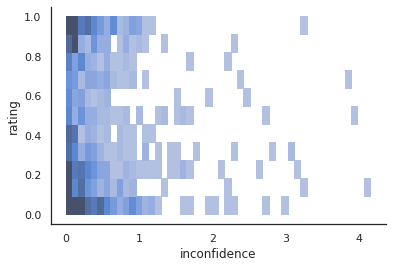

In [9]:
g = sns.histplot(df_sel, x='inconfidence', y='rating', pmax=0.7)
sns.despine()

In [10]:
# significant correlations for ranking questions
corr_ran = pg.pairwise_corr(df_ran, columns=['rating'], method='spearman') # use spearman because of distribution of ratings
corr_ran[corr_ran['p-unc']<0.05].sort_values(by=['adj_r2'], ascending=False).drop(['tail','n','CI95%','r2','r','power'], axis=1)

,X,Y,method,adj_r2,z,p-unc
7,rating,question.sum_of_diff,spearman,0.225086,0.517332,2.285840e-77
6,rating,question.ordering_utility,spearman,0.212490,0.500140,1.274301e-72
19,rating,user.genderParity,spearman,0.046331,0.222102,5.418124e-16
8,rating,question.rND,spearman,0.040566,0.207843,2.664432e-14
11,rating,user.accuracy,spearman,0.033507,-0.189165,4.916932e-12
1,rating,secondsElapsed,spearman,0.018821,0.143352,1.432421e-07
5,rating,question.cluster,spearman,0.008307,0.099181,2.692677e-04
16,rating,user.edu,spearman,0.007236,-0.093564,5.878446e-04
23,rating,user.screenWidth,spearman,0.004114,-0.074880,5.931958e-03
22,rating,user.screenHeight,spearman,0.003418,-0.070053,1.004474e-02


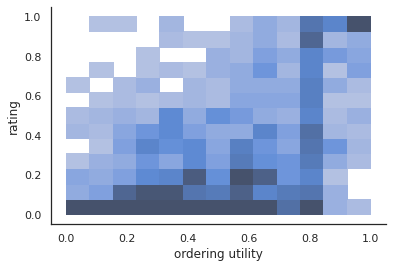

In [11]:
ax = sns.histplot(df_ran, x='question.ordering_utility', y='rating', pmax=0.7)
ax.set(xlabel='ordering utility')
sns.despine()

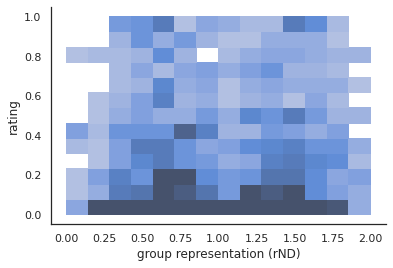

In [12]:
ax = sns.histplot(df_ran, x='question.new_rND', y='rating', pmax=0.7)
ax.set(xlabel='group representation (rND)')
sns.despine()

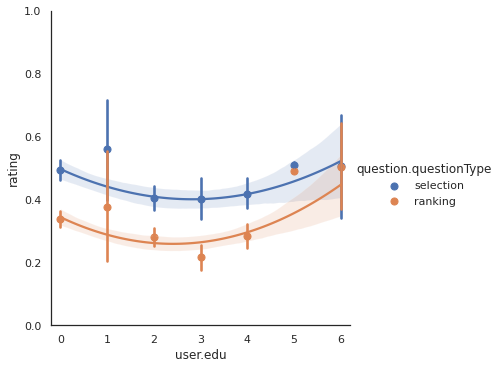

In [13]:
# general correlations with user.edu, user.age and secondsElapsed
g = sns.lmplot(data=df, x='user.edu', y='rating', hue='question.questionType', x_estimator=np.mean, order=2)
g.set(ylim=(0, 1), xlim=(-.2,6.2))

[(0.0, 1.0), (-0.2, 6.2)]

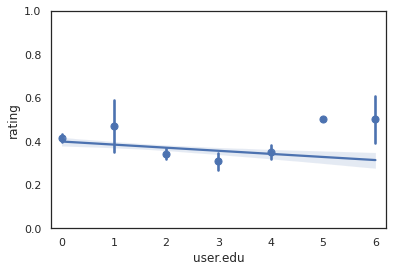

In [14]:
g = sns.regplot(data=df, x='user.edu', y='rating', x_estimator=np.mean)
g.set(ylim=(0, 1), xlim=(-.2,6.2))

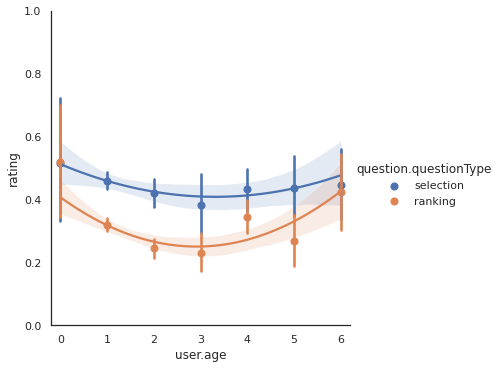

In [15]:
g = sns.lmplot(data=df, x='user.age', y='rating', hue='question.questionType', x_estimator=np.mean, order=2)
g.set(ylim=(0, 1), xlim=(-.2,6.2))

[(0.0, 1.0), (-0.2, 6.2)]

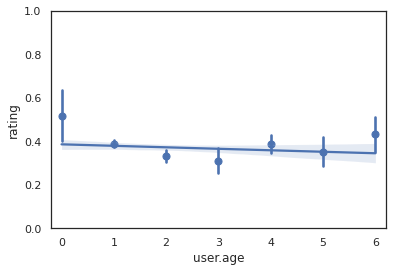

In [16]:
g = sns.regplot(data=df, x='user.age', y='rating', x_estimator=np.mean)
g.set(ylim=(0, 1), xlim=(-.2,6.2))

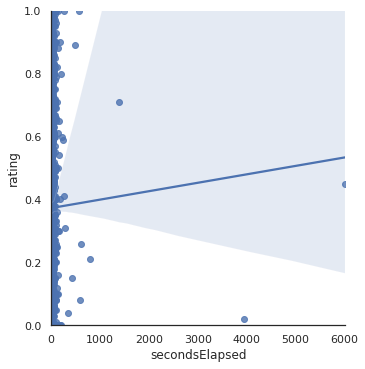

In [17]:
g = sns.lmplot(data=df, x='secondsElapsed', y='rating')
g.set(ylim=(0, 1))

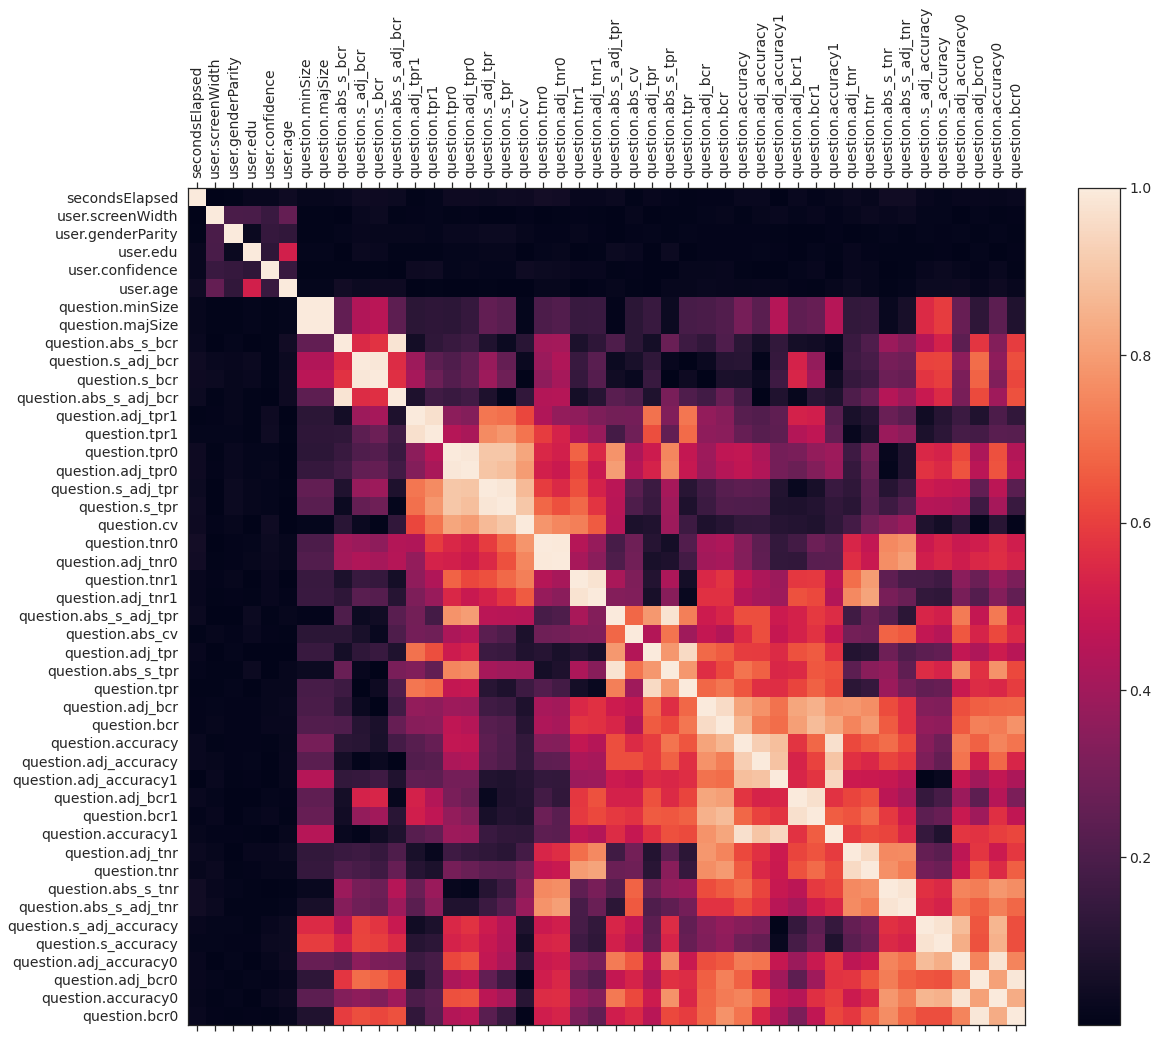

In [18]:
# clustered heatmap for feature selection for selection questions

significant = corr_sel['p-unc']<0.05
reduced_cols = df[corr_sel[significant]['Y']]

# cluster and reindex
X = reduced_cols.corr().abs().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [reduced_cols.columns.tolist()[i] for i in list((np.argsort(ind)))]
reduced_cols = reduced_cols.reindex(columns, axis=1)

# plot the heatmap
f = plt.figure(figsize=(19, 15))
plt.matshow(reduced_cols.corr().abs(), fignum=f.number)
plt.xticks(range(reduced_cols.shape[1]), reduced_cols.columns, fontsize=14, rotation=90)
plt.yticks(range(reduced_cols.shape[1]), reduced_cols.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

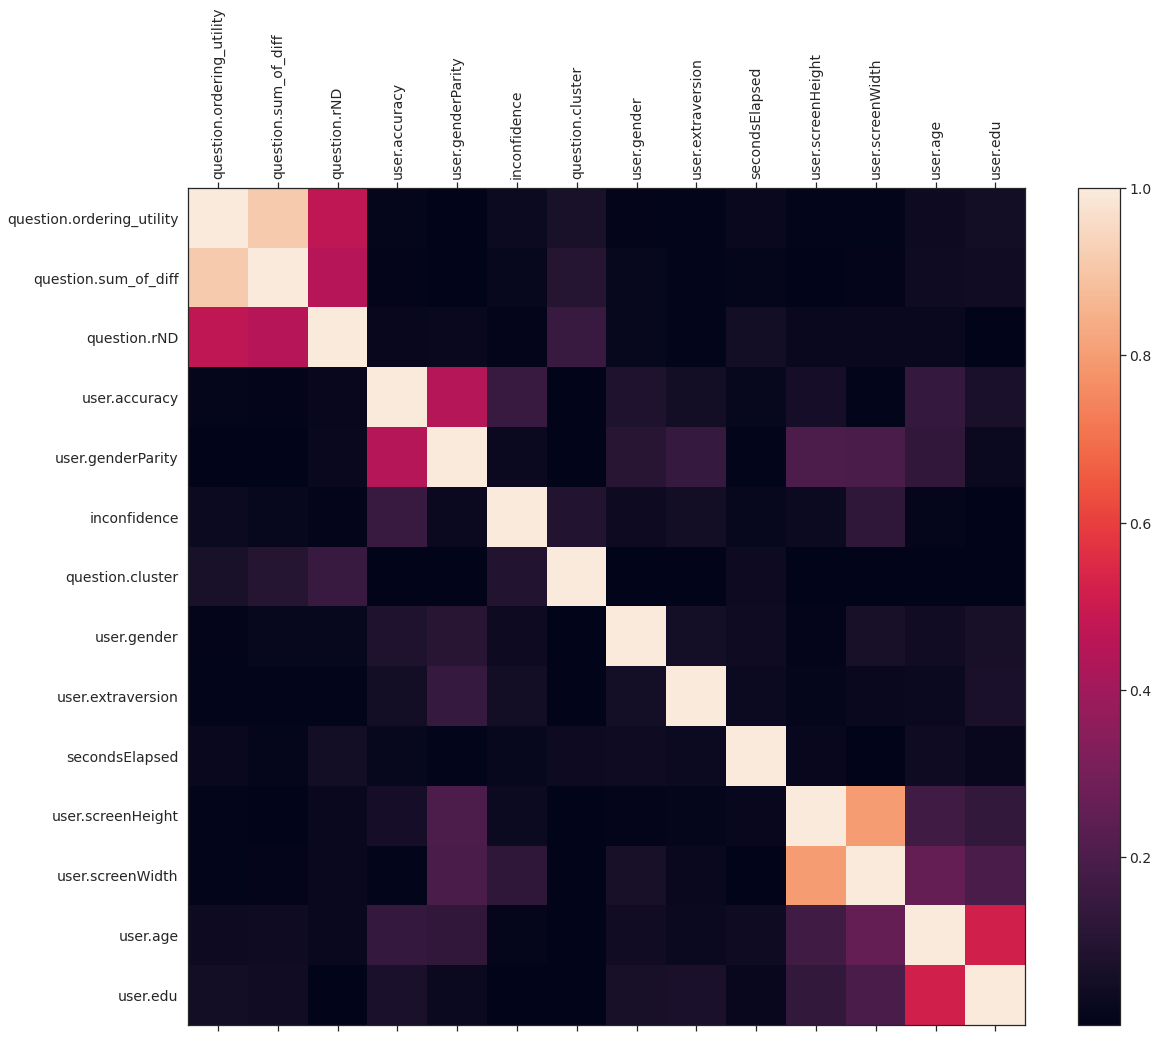

In [19]:
# clustered heatmap for feature selection for ranking questions

significant = corr_ran['p-unc']<0.05
reduced_cols = df[corr_ran[significant]['Y']]

# cluster and reindex
X = reduced_cols.corr().abs().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [reduced_cols.columns.tolist()[i] for i in list((np.argsort(ind)))]
reduced_cols = reduced_cols.reindex(columns, axis=1)

# plot the heatmap
f = plt.figure(figsize=(19, 15))
plt.matshow(reduced_cols.corr().abs(), fignum=f.number)
plt.xticks(range(reduced_cols.shape[1]), reduced_cols.columns, fontsize=14, rotation=90)
plt.yticks(range(reduced_cols.shape[1]), reduced_cols.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)